In [1]:
!pip install google-colab

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.0 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import numpy as np
import cv2
import glob
import tensorflow as tf
import re
from keras import callbacks
from tensorflow.keras.layers import  Input,Conv2D,BatchNormalization,Activation,Subtract,LeakyReLU,Add,Average,Lambda,MaxPool2D,Dropout,UpSampling2D,Concatenate,Multiply,Dense,ZeroPadding2D,AveragePooling2D
from tensorflow.keras.layers import concatenate,Flatten,ConvLSTM2D,Layer,LayerNormalization,ReLU,MaxPooling2D,GlobalAveragePooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt


In [5]:
normal_dir = r"/content/drive/MyDrive/Cleaned_dataset/Normal"
extensions = ["*.png", "*.jpeg", "*.jpg"]
normal_files = []
for ext in extensions:
    """Join the directory path with each extension and using glob.glob() to find matching files which are then
    appended to normal_files list"""
    normal_files.extend(glob.glob(os.path.join(normal_dir, ext)))

In [6]:
pneumonia_dir = r"/content/drive/MyDrive/Cleaned_dataset/Pneumonia"
extensions = ["*.png", "*.jpeg", "*.jpg"]
pneumonia_files = []
for ext in extensions:
    pneumonia_files.extend(glob.glob(os.path.join(pneumonia_dir, ext)))

In [7]:
covid_dir = r"/content/drive/MyDrive/Cleaned_dataset/Covid"
extensions = ["*.png", "*.jpeg", "*.jpg"]
covid_files = []
for ext in extensions:
    covid_files.extend(glob.glob(os.path.join(covid_dir, ext)))

In [8]:
normal_files.sort()
covid_files.sort()
pneumonia_files.sort()

In [9]:
# ~80% of each category is used in the training set
file_lists = [covid_files[:750], normal_files[:750], pneumonia_files[:750]]
labels = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
train_dic = {f: label for file_list, label in zip(file_lists, labels) for f in sorted(file_list)}

In [10]:
import random
# In-place shuffling of training set with 3 as the seed of the random number generator
l = list(train_dic.items())
random.Random(3).shuffle(l)


In [11]:
# ~10% of each category is used in the validation set
file_lists = [covid_files[750:850], normal_files[750:850], pneumonia_files[750:850]]
labels = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
val_dic = {f: label for file_list, label in zip(file_lists, labels) for f in sorted(file_list)}


In [12]:
# In-place shuffling of validation set with 4 as the seed of the random number generator
l_val = list(val_dic.items())
random.seed(4)
random.shuffle(l_val)

In [13]:
# ~10% of each category is used in the test set
file_lists = [covid_files[850:1000], normal_files[850:1000], pneumonia_files[850:1000]]
labels = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]
test_dic = {f: label for file_list, label in zip(file_lists, labels) for f in sorted(file_list)}

In [14]:
# In-place shuffling of testing set with 5 as the seed of the random number generator
l_test = list(test_dic.items())
random.Random(5).shuffle(l_test)


In [15]:
print(len(l),len(l_val),len(l_test))

2250 300 450


In [ ]:
pip install keras-ocr

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: C:\Users\91844\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [ ]:
import keras_ocr
import math

def midpoint(x1, y1, x2, y2):
    x_mid = int((x1 + x2) / 2)
    y_mid = int((y1 + y2) / 2)
    return x_mid, y_mid


def inpaint_text_batch(imgs, pipeline):
    # Recognize text (and corresponding regions) for all images
    prediction_groups = pipeline.recognize(imgs)

    inpainted_imgs = []
    for img, predictions in zip(imgs, prediction_groups):
        # Define the mask for inpainting
        mask = np.zeros(img.shape[:2], dtype="uint8")
        for box in predictions:
            x0, y0 = box[1][0]
            x1, y1 = box[1][1]
            x2, y2 = box[1][2]
            x3, y3 = box[1][3]

            x_mid0, y_mid0 = midpoint(x1, y1, x2, y2)
            x_mid1, y_mi1 = midpoint(x0, y0, x3, y3)

            # For the line thickness, we will calculate the length of the line between
            # the top-left corner and the bottom-left corner.
            thickness = int(math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2))

            # Define the line and inpaint
            cv2.line(mask, (x_mid0, y_mid0), (x_mid1, y_mi1), (255,), thickness)
            inpainted_img = cv2.inpaint(img, mask, 4, cv2.INPAINT_NS)

            if inpainted_img is None:
              inpainted_img = img
            else:
              inpained_img = inpainted_img.astype('float32')/255.0
            inpainted_imgs.append(inpainted_img)

    return inpainted_imgs
pipeline = keras_ocr.pipeline.Pipeline()

Looking for C:\Users\91844\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\91844\.keras-ocr\crnn_kurapan.h5


In [16]:
# Define the CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))

data = []
labels = []

for f, label in l_val:
    # Read and resize image
    img = cv2.imread(f)
    img = cv2.resize(img, (224, 224), interpolation=cv2.INTER_CUBIC)

    # Convert the image to grayscale, apply CLAHE and then convert it back to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    img = clahe.apply(img)
    img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    # Normalize the image and append image and label to corresponding lists
    img = img.astype('float')/255.0
    data.append(img)
    labels.append(label)

# Cast lists to numpy arrays
val_data = np.array(data)
val_labels = np.array(labels)


print(val_data.shape)
print(val_labels.shape)
print("Validation set pre-processing completed")

(300, 224, 224, 3)
(300, 3)
Validation set pre-processing completed


In [17]:
data = []
labels = []
for f,label in l:
  img = cv2.imread(f)
  img = cv2.resize(img,(224,224),interpolation = cv2.INTER_CUBIC)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  img = clahe.apply(img)
  img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  img = img.astype('float32')/255.0
  data.append(img)
  labels.append(label)

train_data = np.array(data)
train_labels = np.array(labels)
print(train_data.shape)
print(train_labels.shape)
print('Training set pre-processing completed')

(2250, 224, 224, 3)
(2250, 3)
Training set pre-processing completed


In [18]:
data = []
labels = []
for f,label in l_test:
  img = cv2.imread(f)
  img = cv2.resize(img,(224,224),interpolation = cv2.INTER_CUBIC)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  img = clahe.apply(img)
  img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
  img = img.astype('float32')/255.0
  data.append(img)
  labels.append(label)

test_data = np.array(data)
test_labels = np.array(labels)
print(test_data.shape)
print(test_labels.shape)
print('Testing set pre-processing completed')

(450, 224, 224, 3)
(450, 3)
Testing set pre-processing completed


In [19]:
Densenet_model = tf.keras.applications.DenseNet121(include_top=False,weights='imagenet',classes = 3)

29084464/29084464 [==============================] - 0s 0us/step


In [20]:
Densenet_model.trainable = False

In [21]:
class ExpandDimsLayer(tf.keras.layers.Layer):
    def __init__(self, axis, **kwargs):
        super(ExpandDimsLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)

inputs = tf.keras.Input(shape=(224,224,3))
x = Densenet_model(inputs)
input_ = ExpandDimsLayer(axis=1)(x)
nb_chan = 512
ratio = 16
x3 = ConvLSTM2D(filters=512, kernel_size=(1,1),padding = "same")(input_)
x3 = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x3)
x3 = Activation('relu')(x3)


y = tf.keras.layers.GlobalAveragePooling2D()(x3)
y = tf.keras.layers.Dense(nb_chan // ratio, activation='relu')(y)
y = tf.keras.layers.Dense(nb_chan, activation='sigmoid')(y)
y_3 = tf.keras.layers.Multiply()([x3, y])

ratio = 16
flat = Flatten()(y_3)

dense_1 = Dense(4096,activation = 'relu')(flat)
dense_2 = Dense(4096,activation = 'relu')(dense_1)
prediction = Dense(3,activation = 'softmax')(dense_2)
Densenet_pred = Model(inputs = inputs,outputs = prediction)


In [22]:
Densenet_pred.summary()
Densenet_pred.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 densenet121 (Functional)    (None, None, None, 1024)     7037504   ['input_2[0][0]']             
                                                                                                  
 expand_dims_layer (ExpandD  (None, 1, 7, 7, 1024)        0         ['densenet121[0][0]']         
 imsLayer)                                                                                        
                                                                                                  
 conv_lstm2d (ConvLSTM2D)    (None, 7, 7, 512)            3147776   ['expand_dims_layer[0][0]'

In [23]:
earlystopping_dense = callbacks.EarlyStopping(monitor="val_accuracy",
                                        mode="max",
                                        patience=7,
                                        restore_best_weights=True)
dense_history = Densenet_pred.fit(train_data,train_labels,validation_data=(val_data, val_labels),callbacks=[earlystopping_dense],epochs = 20)

Epoch 1/20
71/71 [==============================] - 88s 1s/step - loss: 0.7318 - accuracy: 0.8129 - precision: 0.8270 - recall: 0.7991 - val_loss: 0.2068 - val_accuracy: 0.9233 - val_precision: 0.9233 - val_recall: 0.9233
Epoch 2/20
71/71 [==============================] - 77s 1s/step - loss: 0.1677 - accuracy: 0.9333 - precision: 0.9343 - recall: 0.9298 - val_loss: 0.1875 - val_accuracy: 0.9433 - val_precision: 0.9431 - val_recall: 0.9400
Epoch 3/20
71/71 [==============================] - 75s 1s/step - loss: 0.0781 - accuracy: 0.9742 - precision: 0.9746 - recall: 0.9729 - val_loss: 0.0890 - val_accuracy: 0.9633 - val_precision: 0.9666 - val_recall: 0.9633
Epoch 4/20
71/71 [==============================] - 75s 1s/step - loss: 0.0387 - accuracy: 0.9880 - precision: 0.9880 - recall: 0.9880 - val_loss: 0.6066 - val_accuracy: 0.9000 - val_precision: 0.9060 - val_recall: 0.9000
Epoch 5/20
71/71 [==============================] - 74s 1s/step - loss: 0.0112 - accuracy: 0.9956 - precision: 0

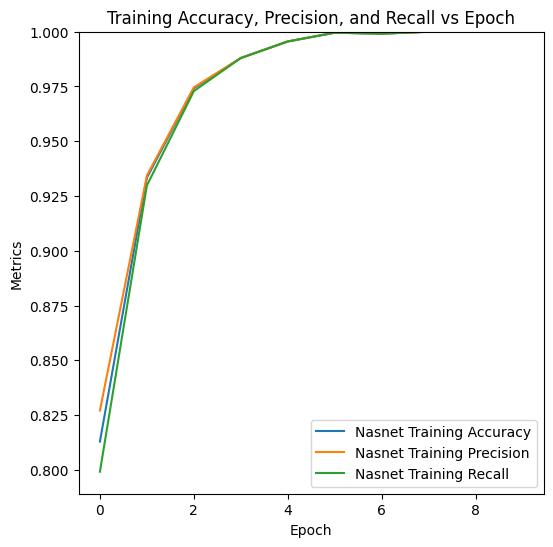

In [24]:
acc = dense_history.history['accuracy']
prec = dense_history.history['precision']
recall = dense_history.history['recall']

plt.figure(figsize=(6, 6))

# Plotting Accuracy
plt.plot( acc, label='Densenet Training Accuracy')

# Plotting Precision
plt.plot( prec, label='Densenet Training Precision')

# Plotting Recall
plt.plot( recall, label='Densenet Training Recall')

plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy, Precision, and Recall vs Epoch')
plt.show()


In [25]:
vgg_model = tf.keras.applications.VGG19(include_top=False,weights='imagenet',classes = 3)

80134624/80134624 [==============================] - 1s 0us/step


In [26]:
vgg_model.trainable = False

In [27]:
class ExpandDimsLayer(tf.keras.layers.Layer):
    def __init__(self, axis, **kwargs):
        super(ExpandDimsLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)

inputs = tf.keras.Input(shape=(224,224,3))
x = vgg_model(inputs)
input_ = ExpandDimsLayer(axis=1)(x)
nb_chan = 512
ratio = 16
x3 = ConvLSTM2D(filters=512, kernel_size=(1,1),padding = "same")(input_)
x3 = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x3)
x3 = Activation('relu')(x3)

#x_add = Add()([x1,x3])
y = tf.keras.layers.GlobalAveragePooling2D()(x3)
y = tf.keras.layers.Dense(nb_chan // ratio, activation='relu')(y)
y = tf.keras.layers.Dense(nb_chan, activation='sigmoid')(y)
y_3 = tf.keras.layers.Multiply()([x3, y])

ratio = 16
flat = Flatten()(y_3)

dense_1 = Dense(4096,activation = 'relu')(flat)
dense_2 = Dense(4096,activation = 'relu')(dense_1)
prediction = Dense(3,activation = 'softmax')(dense_2)
vgg_pred = Model(inputs = inputs,outputs = prediction)

In [28]:
vgg_pred.summary()
vgg_pred.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False) , metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 vgg19 (Functional)          (None, None, None, 512)      2002438   ['input_4[0][0]']             
                                                          4                                       
                                                                                                  
 expand_dims_layer_1 (Expan  (None, 1, 7, 7, 512)         0         ['vgg19[0][0]']               
 dDimsLayer)                                                                                      
                                                                                            

In [29]:
earlystopping_vgg = callbacks.EarlyStopping(monitor="val_accuracy",
                                        mode="max",
                                        patience=7,
                                        restore_best_weights=True)
vgg_history = vgg_pred.fit(train_data,train_labels,validation_data=(val_data, val_labels),callbacks=[earlystopping_vgg],epochs = 20)

Epoch 1/20
71/71 [==============================] - 91s 1s/step - loss: 0.6804 - accuracy: 0.7964 - precision_1: 0.8122 - recall_1: 0.7822 - val_loss: 0.3534 - val_accuracy: 0.8400 - val_precision_1: 0.8485 - val_recall_1: 0.8400
Epoch 2/20
71/71 [==============================] - 87s 1s/step - loss: 0.1788 - accuracy: 0.9373 - precision_1: 0.9404 - recall_1: 0.9324 - val_loss: 0.1537 - val_accuracy: 0.9600 - val_precision_1: 0.9628 - val_recall_1: 0.9500
Epoch 3/20
71/71 [==============================] - 87s 1s/step - loss: 0.1141 - accuracy: 0.9596 - precision_1: 0.9608 - recall_1: 0.9587 - val_loss: 0.1513 - val_accuracy: 0.9500 - val_precision_1: 0.9500 - val_recall_1: 0.9500
Epoch 4/20
71/71 [==============================] - 87s 1s/step - loss: 0.0612 - accuracy: 0.9822 - precision_1: 0.9827 - recall_1: 0.9818 - val_loss: 0.0942 - val_accuracy: 0.9733 - val_precision_1: 0.9733 - val_recall_1: 0.9733
Epoch 5/20
71/71 [==============================] - 87s 1s/step - loss: 0.0322 -

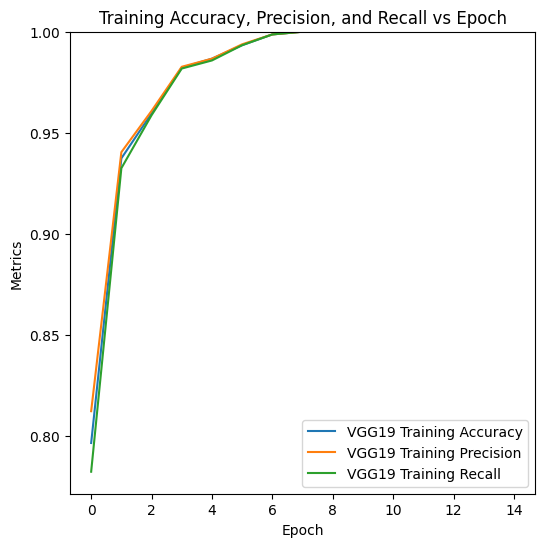

In [30]:
acc = vgg_history.history['accuracy']
prec = vgg_history.history['precision_1']
recall = vgg_history.history['recall_1']

plt.figure(figsize=(6, 6))

# Plotting Accuracy
plt.plot( acc, label='VGG19 Training Accuracy')

# Plotting Precision
plt.plot( prec, label='VGG19 Training Precision')

# Plotting Recall
plt.plot( recall, label='VGG19 Training Recall')

plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy, Precision, and Recall vs Epoch')
plt.show()

In [31]:
mobile_model = tf.keras.applications.MobileNet(input_shape=(224,224,3),include_top=False,weights='imagenet',classes = 3)

17225924/17225924 [==============================] - 0s 0us/step


In [32]:
mobile_model.trainable = False

In [33]:
class ExpandDimsLayer(tf.keras.layers.Layer):
    def __init__(self, axis, **kwargs):
        super(ExpandDimsLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)

inputs = tf.keras.Input(shape=(224,224,3))
x = mobile_model(inputs)
input_ = ExpandDimsLayer(axis=1)(x)
nb_chan = 512
ratio = 16
x3 = ConvLSTM2D(filters=512, kernel_size=(1,1),padding = "same")(input_)
x3 = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x3)
x3 = Activation('relu')(x3)


y = tf.keras.layers.GlobalAveragePooling2D()(x3)
y = tf.keras.layers.Dense(nb_chan // ratio, activation='relu')(y)
y = tf.keras.layers.Dense(nb_chan, activation='sigmoid')(y)
y_3 = tf.keras.layers.Multiply()([x3, y])

ratio = 16
flat = Flatten()(y_3)
dense_1 = Dense(4096,activation = 'relu')(flat)
dense_2 = Dense(4096,activation = 'relu')(dense_1)
prediction = Dense(3,activation = 'softmax')(dense_2)
mobile_pred = Model(inputs = inputs,outputs = prediction)

In [34]:
mobile_pred.summary()
mobile_pred.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001), loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False) , metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_6 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 mobilenet_1.00_224 (Functi  (None, 7, 7, 1024)           3228864   ['input_6[0][0]']             
 onal)                                                                                            
                                                                                                  
 expand_dims_layer_2 (Expan  (None, 1, 7, 7, 1024)        0         ['mobilenet_1.00_224[0][0]']  
 dDimsLayer)                                                                                      
                                                                                            

In [35]:
earlystopping_mobile = callbacks.EarlyStopping(monitor="val_accuracy",
                                        mode="max",
                                        patience=7,
                                        restore_best_weights=True)
mobile_history = mobile_pred.fit(train_data,train_labels,validation_data=(val_data, val_labels),callbacks=[earlystopping_mobile],epochs = 20)

Epoch 1/20
71/71 [==============================] - 47s 607ms/step - loss: 0.4013 - accuracy: 0.8449 - precision_2: 0.8805 - recall_2: 0.8027 - val_loss: 0.2236 - val_accuracy: 0.9267 - val_precision_2: 0.9295 - val_recall_2: 0.9233
Epoch 2/20
71/71 [==============================] - 42s 588ms/step - loss: 0.1280 - accuracy: 0.9627 - precision_2: 0.9648 - recall_2: 0.9618 - val_loss: 0.1906 - val_accuracy: 0.9400 - val_precision_2: 0.9396 - val_recall_2: 0.9333
Epoch 3/20
71/71 [==============================] - 42s 586ms/step - loss: 0.0595 - accuracy: 0.9889 - precision_2: 0.9902 - recall_2: 0.9889 - val_loss: 0.1646 - val_accuracy: 0.9333 - val_precision_2: 0.9327 - val_recall_2: 0.9233
Epoch 4/20
71/71 [==============================] - 42s 589ms/step - loss: 0.0295 - accuracy: 0.9969 - precision_2: 0.9978 - recall_2: 0.9964 - val_loss: 0.1446 - val_accuracy: 0.9433 - val_precision_2: 0.9465 - val_recall_2: 0.9433
Epoch 5/20
71/71 [==============================] - 41s 581ms/step -

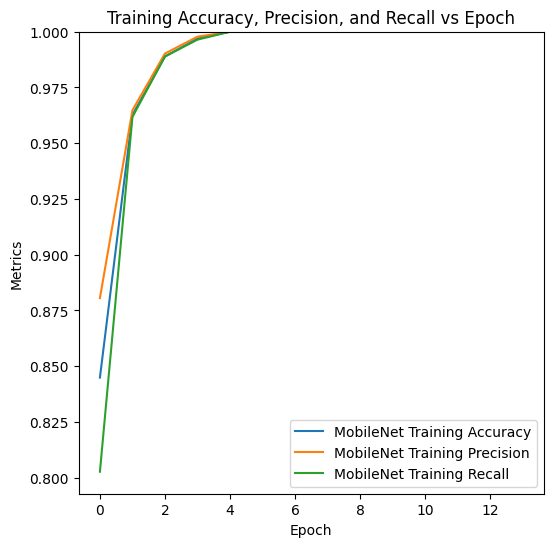

In [36]:
acc = mobile_history.history['accuracy']
prec = mobile_history.history['precision_2']
recall = mobile_history.history['recall_2']

plt.figure(figsize=(6, 6))

# Plotting Accuracy
plt.plot( acc, label='MobileNet Training Accuracy')

# Plotting Precision
plt.plot( prec, label='MobileNet Training Precision')

# Plotting Recall
plt.plot( recall, label='MobileNet Training Recall')

plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy, Precision, and Recall vs Epoch')
plt.show()

In [131]:
Xception_model = tf.keras.applications.Xception(include_top=False,weights='imagenet')

83683744/83683744 [==============================] - 0s 0us/step


In [132]:
Xception_model.trainable = False

In [133]:
class ExpandDimsLayer(tf.keras.layers.Layer):
    def __init__(self, axis, **kwargs):
        super(ExpandDimsLayer, self).__init__(**kwargs)
        self.axis = axis

    def call(self, inputs):
        return tf.expand_dims(inputs, axis=self.axis)
inputs = tf.keras.Input(shape=(224,224,3))
x = Xception_model(inputs)
input_ = ExpandDimsLayer(axis=1)(x)
nb_chan = 512
ratio = 16
x3 = ConvLSTM2D(filters=512, kernel_size=(1,1),padding = "same")(input_)
x3 = BatchNormalization(axis=3, momentum=0.0,epsilon=0.0001)(x3)
x3 = Activation('relu')(x3)

#x_add = Add()([x1,x3])
y = tf.keras.layers.GlobalAveragePooling2D()(x3)
y = tf.keras.layers.Dense(nb_chan // ratio, activation='relu')(y)
y = tf.keras.layers.Dense(nb_chan, activation='sigmoid')(y)
y_3 = tf.keras.layers.Multiply()([x3, y])

ratio = 16
flat = Flatten()(y_3)

dense_1 = Dense(4096,activation = 'relu')(flat)
dense_2 = Dense(4096,activation = 'relu')(dense_1)
prediction = Dense(3,activation = 'softmax')(dense_2)
Xception_pred = Model(inputs = inputs,outputs = prediction)

In [134]:
Xception_pred.summary()
Xception_pred.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.0001), loss=tf.keras.losses.CategoricalCrossentropy(from_logits = False) , metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_14 (InputLayer)       [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 xception (Functional)       (None, None, None, 2048)     2086148   ['input_14[0][0]']            
                                                          0                                       
                                                                                                  
 expand_dims_layer_6 (Expan  (None, 1, 7, 7, 2048)        0         ['xception[0][0]']            
 dDimsLayer)                                                                                      
                                                                                            

In [135]:
earlystopping_xc = callbacks.EarlyStopping(monitor="val_accuracy",
                                        mode="max",
                                        patience=7,
                                        restore_best_weights=True)
xc_history = Xception_pred.fit(train_data,train_labels,validation_data=(val_data, val_labels),callbacks=[earlystopping_res],epochs = 20)

Epoch 1/20
71/71 [==============================] - 73s 945ms/step - loss: 0.6847 - accuracy: 0.7738 - precision_6: 0.7895 - recall_6: 0.7551 - val_loss: 0.4553 - val_accuracy: 0.8100 - val_precision_6: 0.8169 - val_recall_6: 0.8033
Epoch 2/20
71/71 [==============================] - 66s 935ms/step - loss: 0.2401 - accuracy: 0.9102 - precision_6: 0.9117 - recall_6: 0.9084 - val_loss: 0.3340 - val_accuracy: 0.8867 - val_precision_6: 0.8867 - val_recall_6: 0.8867
Epoch 3/20
71/71 [==============================] - 67s 949ms/step - loss: 0.1421 - accuracy: 0.9484 - precision_6: 0.9493 - recall_6: 0.9480 - val_loss: 0.4656 - val_accuracy: 0.8467 - val_precision_6: 0.8519 - val_recall_6: 0.8433
Epoch 4/20
71/71 [==============================] - 67s 946ms/step - loss: 0.0997 - accuracy: 0.9667 - precision_6: 0.9675 - recall_6: 0.9662 - val_loss: 0.2559 - val_accuracy: 0.9333 - val_precision_6: 0.9331 - val_recall_6: 0.9300
Epoch 5/20
71/71 [==============================] - 67s 938ms/step -

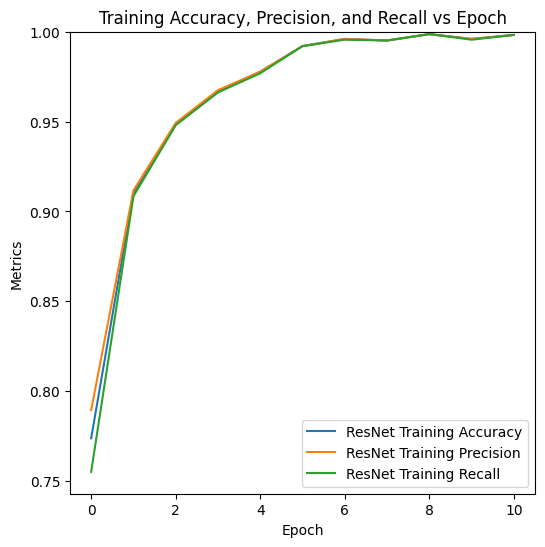

In [137]:

acc = xc_history.history['accuracy']
prec = xc_history.history['precision_6']
recall = xc_history.history['recall_6']

plt.figure(figsize=(6, 6))

# Plotting Accuracy
plt.plot( acc, label='Xception Training Accuracy')

# Plotting Precision
plt.plot( prec, label='Xception Training Precision')

# Plotting Recall
plt.plot( recall, label='Xception Training Recall')

plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.ylim([min(plt.ylim()),1])
plt.title('Training Accuracy, Precision, and Recall vs Epoch')
plt.show()

In [141]:
vgg_pred.evaluate(val_data,val_labels)
mobile_pred.evaluate(val_data,val_labels)
Densenet_pred.evaluate(val_data,val_labels)
Xception_pred.evaluate(val_data,val_labels)

10/10 [==============================] - 5s 454ms/step - loss: 0.2559 - accuracy: 0.9333 - precision_6: 0.9331 - recall_6: 0.9300


[0.2558932602405548,
 0.9333333373069763,
 0.9331103563308716,
 0.9300000071525574]

In [142]:
val_vgg = vgg_pred.predict(val_data)
val_mob = mobile_pred.predict(val_data)
val_dense = Densenet_pred.predict(val_data)
val_xc = Xception_pred.predict(val_data)

10/10 [==============================] - 4s 439ms/step


In [191]:
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_val_true_label_encoded = np.argmax(val_labels, axis=1)
y_val_models = [np.argmax(val_vgg,axis=1),np.argmax(val_mob,axis=1),np.argmax(val_dense,axis=1),np.argmax(val_xc,axis=1)]
accuracy_scores_model = [accuracy_score(y_val_true_label_encoded, _) for _ in y_val_models]
print("The accuracy on validation set of vgg, mobile, Densenet, Xception are:\n")
print(accuracy_scores_model)
# Weights chosen experimentally on validation data
chosen_weights = [1,1,1,0.2]
# Multiply each prediction array with corresponding weight
result_model = np.stack([s * v for s, v in zip(chosen_weights, [val_vgg, val_mob, val_dense, val_xc])])
final_predictions_val_one_hot = np.mean(result_model, axis=0)
y_val_pred_label_encoded = np.argmax(final_predictions_val_one_hot,axis=1)

# Calculate accuracy and print the classification report
accuracy_val = accuracy_score(y_val_true_label_encoded, y_val_pred_label_encoded)
print(f'Validation Accuracy: {accuracy_val}')
report_val = classification_report(y_val_true_label_encoded, y_val_pred_label_encoded,
               labels=[0, 1, 2], target_names=['Covid', 'Normal', 'Pneumonia'])
print(report_val)

The accuracy on validation set of vgg, mobile, Nasnet, resnet are:

[0.98, 0.9633333333333334, 0.9633333333333334, 0.9333333333333333]
Validation Accuracy: 0.9833333333333333
              precision    recall  f1-score   support

       Covid       0.99      0.98      0.98       100
      Normal       0.97      0.98      0.98       100
   Pneumonia       0.99      0.99      0.99       100

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



Confusion Matrix of Validation Set:
[[98  2  0]
 [ 1 98  1]
 [ 0  1 99]]


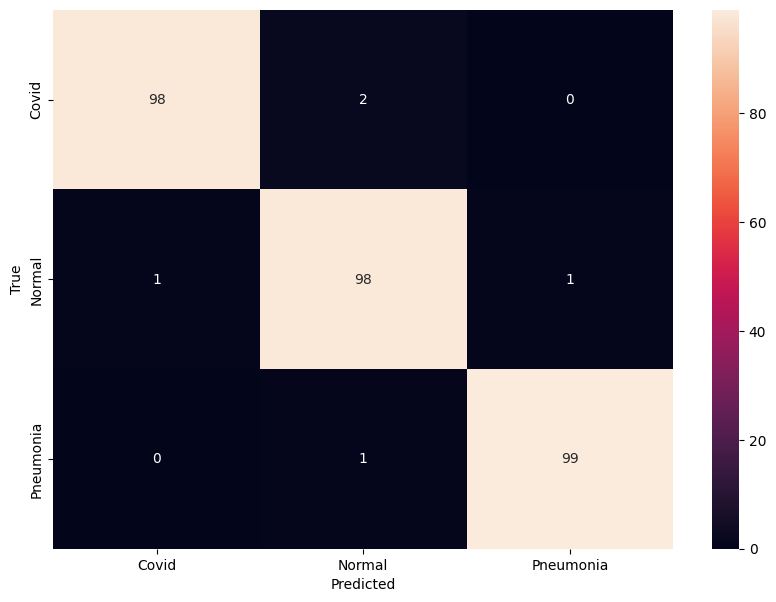

In [193]:
cm_val = confusion_matrix(y_val_true_label_encoded, y_val_pred_label_encoded)

# Print the confusion matrix
print('Confusion Matrix of Validation Set:')
print(cm_val)

# Visualize the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_val, annot=True, fmt='d', xticklabels=['Covid', 'Normal', 'Pneumonia'],
            yticklabels=['Covid', 'Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [138]:
vgg_pred.evaluate(test_data,test_labels)
mobile_pred.evaluate(test_data,test_labels)
Densenet_pred.evaluate(test_data,test_labels)
Xception_pred.evaluate(test_data,test_labels)

15/15 [==============================] - 7s 452ms/step - loss: 0.3827 - accuracy: 0.9000 - precision_6: 0.9000 - recall_6: 0.9000


[0.3826847970485687,
 0.8999999761581421,
 0.8999999761581421,
 0.8999999761581421]

In [139]:
test_vgg = vgg_pred.predict(test_data)
test_mob = mobile_pred.predict(test_data)
test_Dense = Densenet_pred.predict(test_data)
test_xc = Xception_pred.predict(test_data)


15/15 [==============================] - 8s 471ms/step


In [192]:
# Each model's softmax output is multiplied by corresponding weight
softmax_outputs_test = np.stack([s * v for s, v in zip(chosen_weights, [test_vgg, test_mob, test_xc, test_Dense])])
final_predictions_test_one_hot = np.mean(softmax_outputs_test, axis=0)

# Convert one-hot encoded labels and predictions to label-encoded form
y_test_true_label_encoded = np.argmax(test_labels, axis=1)
y_test_pred_label_encoded = np.argmax(final_predictions_test_one_hot, axis=1)

y_test_pred_models = [np.argmax(test_vgg,axis=1),np.argmax(test_mob,axis=1),np.argmax(test_xc,axis=1),np.argmax(test_Dense,axis=1)]
accuracy_models_test = [accuracy_score(mid,y_test_true_label_encoded) for mid in y_test_pred_models]
print("The accuracy on test set of vgg, mobile, Densenet, Xception are:\n")
print(accuracy_models_test)

# Calculate accuracy and print the classification report
accuracy_test = accuracy_score(y_test_true_label_encoded, y_test_pred_label_encoded)
print(f'Accuracy: {accuracy_test}')
report_test = classification_report(y_test_true_label_encoded, y_test_pred_label_encoded,
               labels=[0, 1, 2], target_names=['Covid', 'Normal', 'Pneumonia'])
print(report_test)

The accuracy on test set of vgg, mobile, Nasnet, resnet are:

[0.9177777777777778, 0.9266666666666666, 0.9311111111111111, 0.9]
Accuracy: 0.9444444444444444
              precision    recall  f1-score   support

       Covid       0.94      0.95      0.95       150
      Normal       0.91      0.94      0.92       150
   Pneumonia       0.99      0.94      0.96       150

    accuracy                           0.94       450
   macro avg       0.95      0.94      0.94       450
weighted avg       0.95      0.94      0.94       450



Confusion Matrix of Test Set:
[[143   5   2]
 [  9 141   0]
 [  0   9 141]]


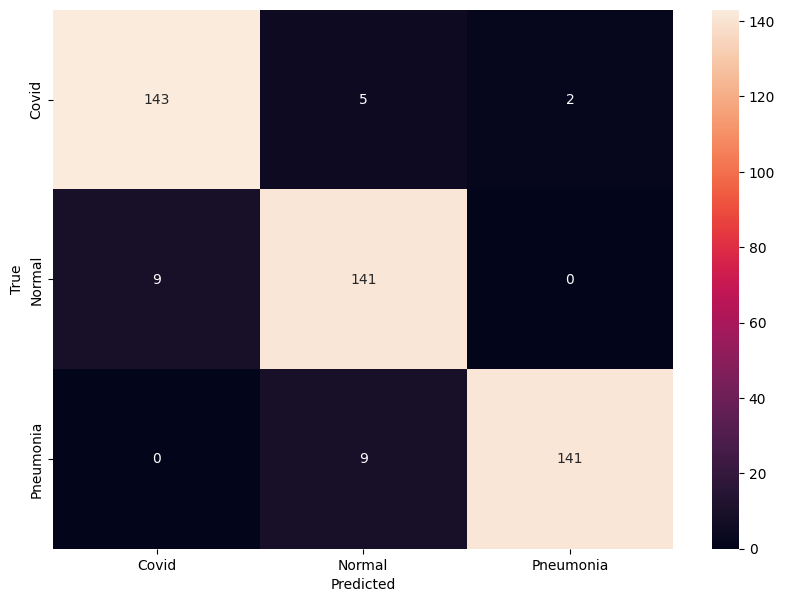

In [194]:
cm_test = confusion_matrix(y_test_true_label_encoded, y_test_pred_label_encoded)

# Print the confusion matrix
print('Confusion Matrix of Test Set:')
print(cm_test)

# Visualize the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_test, annot=True, fmt='d', xticklabels=['Covid', 'Normal', 'Pneumonia'],
            yticklabels=['Covid', 'Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [195]:
train_vgg = vgg_pred.predict(train_data)
train_mob = mobile_pred.predict(train_data)
train_Dense = Densenet_pred.predict(train_data)
train_xc = Xception_pred.predict(train_data)

71/71 [==============================] - 34s 472ms/step


In [196]:
# Each model's softmax output is multiplied by corresponding weight
softmax_outputs_train = np.stack([s * v for s, v in zip(chosen_weights, [train_vgg, train_mob, train_xc, train_Dense])])
final_predictions_train_one_hot = np.mean(softmax_outputs_train, axis=0)

# Convert one-hot encoded labels and predictions to label-encoded form
y_train_true_label_encoded = np.argmax(train_labels, axis=1)
y_train_pred_label_encoded = np.argmax(final_predictions_train_one_hot, axis=1)

y_train_pred_models = [np.argmax(train_vgg,axis=1),np.argmax(train_mob,axis=1),np.argmax(train_xc,axis=1),np.argmax(train_Dense,axis=1)]
accuracy_models_train = [accuracy_score(mid,y_train_true_label_encoded) for mid in y_train_pred_models]
print("The accuracy on training set of vgg, mobile, Densenet, Xception are:\n")
print(accuracy_models_train)

# Calculate accuracy and print the classification report
accuracy_train = accuracy_score(y_train_true_label_encoded, y_train_pred_label_encoded)
print(f'Accuracy: {accuracy_train}')
report_test = classification_report(y_train_true_label_encoded, y_train_pred_label_encoded,
               labels=[0, 1, 2], target_names=['Covid', 'Normal', 'Pneumonia'])
print(report_test)

The accuracy on training set of vgg, mobile, Nasnet, resnet are:

[1.0, 1.0, 0.9986666666666667, 0.9853333333333333]
Accuracy: 1.0
              precision    recall  f1-score   support

       Covid       1.00      1.00      1.00       750
      Normal       1.00      1.00      1.00       750
   Pneumonia       1.00      1.00      1.00       750

    accuracy                           1.00      2250
   macro avg       1.00      1.00      1.00      2250
weighted avg       1.00      1.00      1.00      2250



Confusion Matrix of Training Set:
[[750   0   0]
 [  0 750   0]
 [  0   0 750]]


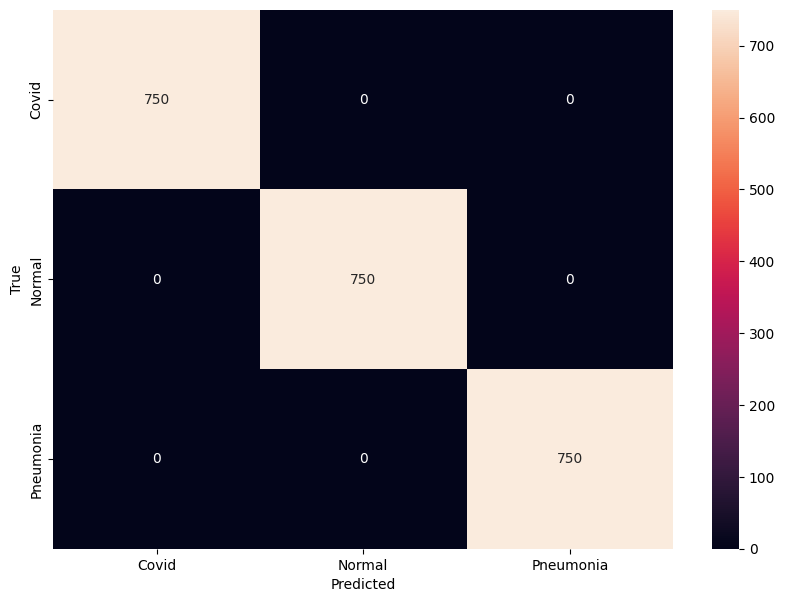

In [197]:
cm_train = confusion_matrix(y_train_true_label_encoded, y_train_pred_label_encoded)

# Print the confusion matrix
print('Confusion Matrix of Training Set:')
print(cm_train)

# Visualize the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_train, annot=True, fmt='d', xticklabels=['Covid', 'Normal', 'Pneumonia'],
            yticklabels=['Covid', 'Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Confusion Matrix of Total Corpus:
[[991   7   2]
 [ 10 989   1]
 [  0  10 990]]


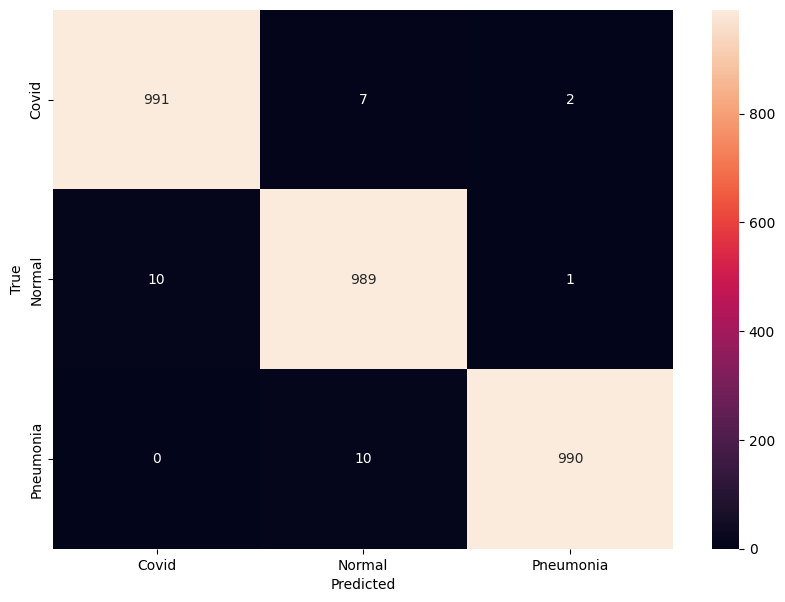

In [198]:
cm_total = cm_train + cm_test + cm_val

# Print the confusion matrix
print('Confusion Matrix of Total Corpus:')
print(cm_total)

# Visualize the confusion matrix
plt.figure(figsize=(10,7))
sns.heatmap(cm_total, annot=True, fmt='d', xticklabels=['Covid', 'Normal', 'Pneumonia'],
            yticklabels=['Covid', 'Normal', 'Pneumonia'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()